# Шаг 0.1. Импорт необходимых библиотек

In [ ]:
!pip install -U lightautoml

In [1]:
# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Стандартные библиотеки python
import logging
import os
import glob
import time
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)

# Установка библиотек
import numpy as np
import pandas as pd
from pandas import Series
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
import torch
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Стандартные библиотеки lightautoml
#from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
#from lightautoml.dataset.roles import DatetimeRole
#from lightautoml.tasks import Task
#from lightautoml.utils.profiler import Profiler

[2022-05-08 04:29:28,363] (INFO): NumExpr defaulting to 2 threads.


# Шаг 0.2. Изменяемые параметры

In [3]:
N_THREADS = 8 # количество CPUs для создания модели LightAutoML
N_FOLDS = 5 # количество групп для кросс-валидации LightAutoML
TEST_SIZE = 0.25 # размер тестовой выборки для определения метрик
TIMEOUT = 30 # максимальное время работы LightAutoML в секундах
TARGET_NAME = 'Porosity, %' # имя колонки с целевой переменной

# Шаг 0.3. Фиксированные параметры

In [4]:
RANDOM_STATE = 42 # фиксируем, для того, чтобы эксперименты были воспроизводимы
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Шаг 0.5. Загрузка и превичный анализ данных 

In [5]:
usecols = ['I, A', 'P, Mpa', 'L, mm', 'V, mm/s']

In [6]:
%%time

pd.set_option('display.max_columns', None)
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/df.xlsx')

CPU times: user 198 ms, sys: 32.2 ms, total: 230 ms
Wall time: 746 ms


In [7]:
df.head(20)

,"I, A","P, Mpa","L, mm","V, mm/s","Porosity, %"
0,150,0.30,150,460,4.8
1,150,0.25,130,380,6.2
2,150,0.25,180,530,4.4
3,150,0.35,180,380,4.7
4,150,0.35,130,530,5.7
5,250,0.30,150,460,4.8
6,250,0.25,130,380,5.0
7,250,0.25,180,530,4.8
8,250,0.35,180,380,3.0
9,250,0.35,130,530,4.8


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   I, A         15 non-null     int64  
 1   P, Mpa       15 non-null     float64
 2   L, mm        15 non-null     int64  
 3   V, mm/s      15 non-null     float64
 4   Porosity, %  15 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 728.0 bytes


In [8]:
df.describe()

,"I, A","P, Mpa","L, mm","V, mm/s","Porosity, %"
count,15.000000,15.000000,15.0000,15.000000,15.000000
mean,233.333333,0.300000,154.0000,456.000000,4.426667
std,64.549722,0.046291,23.2379,69.467361,0.945264
min,150.000000,0.250000,130.0000,380.000000,2.700000
25%,150.000000,0.250000,130.0000,380.000000,3.850000
50%,250.000000,0.300000,150.0000,460.000000,4.700000
75%,300.000000,0.350000,180.0000,530.000000,4.800000
max,300.000000,0.350000,180.0000,530.000000,6.200000


In [ ]:
df.shape

(15, 5)

In [ ]:
df['Porosity, %'].describe()

count    15.000000
mean      4.426667
std       0.945264
min       2.700000
25%       3.850000
50%       4.700000
75%       4.800000
max       6.200000
Name: Porosity, %, dtype: float64

# Шаг 0.6. Разбиение данных на тренировочную и тестовую выборку 

In [ ]:
#df['Porosity, %'] = np.log(df['Porosity, %'] + 1)

In [ ]:
%%time

train_data, test_data = train_test_split(df, 
                                         test_size=TEST_SIZE, 
                                         random_state=RANDOM_STATE)

logging.info('Data splitted. Parts sizes: train_data = {}, test_data = {}'
              .format(train_data.shape, test_data.shape))

[2022-05-06 02:19:32,020] (INFO): Data splitted. Parts sizes: train_data = (11, 5), test_data = (4, 5)


CPU times: user 5.03 ms, sys: 0 ns, total: 5.03 ms
Wall time: 4.74 ms


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 5 to 6
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   I, A         11 non-null     int64  
 1   P, Mpa       11 non-null     float64
 2   L, mm        11 non-null     int64  
 3   V, mm/s      11 non-null     float64
 4   Porosity, %  11 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 528.0 bytes


In [ ]:
numeric_idx = [0, 1, 2, 3, 4]
print(f'Числовые признаки:\n{list(train_data.columns[numeric_idx])}')

Числовые признаки:
['I, A', 'P, Mpa', 'L, mm', 'V, mm/s', 'Porosity, %']


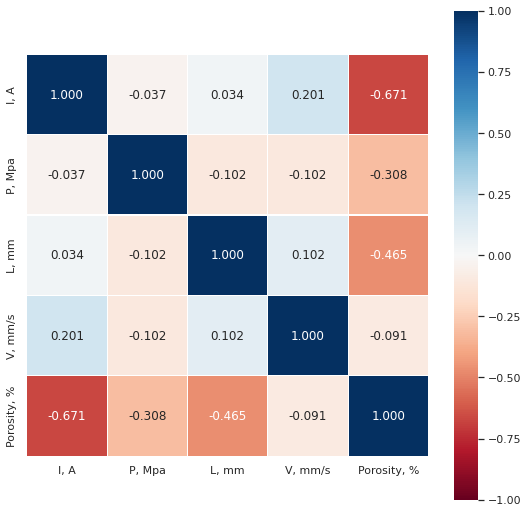

In [ ]:
# Посмотрим корреляции полученных признаков:
sns.set(font_scale=1)
plt.subplots(figsize=(9, 9))
sns.heatmap(train_data.iloc[:, numeric_idx].corr(), square=True,
            annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu", vmin=-1.0, vmax=1.0)

# === Использование AutoML ====

## Шаг 1. Создание задачи

In [ ]:
%%time

task = Task('reg') # задача регрессии по умолчанию
#task = Task('reg', loss='quantile', loss_params={'q': 0.7}, metric='quantile')

CPU times: user 890 µs, sys: 0 ns, total: 890 µs
Wall time: 902 µs


##` Шаг 2. Задание ролей колонок

In [ ]:
%%time

roles = {'target': TARGET_NAME}

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


## Шаг 3. Запуск обучения AutoML

In [ ]:
%%time 
automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS})

oof_pred = automl.fit_predict(train_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

Выходные данные были обрезаны до нескольких последних строк (5000).
[2022-05-05 18:19:57,953] (DEBUG): 254:	learn: 0.9727776	test: 0.2801362	best: 0.2801362 (254)	total: 32.3ms	remaining: 221ms
[2022-05-05 18:19:57,954] (DEBUG): 255:	learn: 0.9727776	test: 0.2801358	best: 0.2801358 (255)	total: 32.4ms	remaining: 221ms
[2022-05-05 18:19:57,956] (DEBUG): 256:	learn: 0.9727776	test: 0.2801355	best: 0.2801355 (256)	total: 32.6ms	remaining: 221ms
[2022-05-05 18:19:57,957] (DEBUG): 257:	learn: 0.9727776	test: 0.2801351	best: 0.2801351 (257)	total: 32.7ms	remaining: 221ms
[2022-05-05 18:19:57,959] (DEBUG): 258:	learn: 0.9727776	test: 0.2801348	best: 0.2801348 (258)	total: 32.8ms	remaining: 221ms
[2022-05-05 18:19:57,960] (DEBUG): 259:	learn: 0.9727776	test: 0.2801343	best: 0.2801343 (259)	total: 32.9ms	remaining: 220ms
[2022-05-05 18:19:57,961] (DEBUG): 260:	learn: 0.9727776	test: 0.2801341	best: 0.2801341 (260)	total: 33.1ms	remaining: 220ms
[2022-05-05 18:19:57,963] (DEBUG): 261:	learn: 0.9

oof_pred:
array([[4.696577 ],
       [3.7773163],
       [4.6407495],
       [5.5000687],
       [3.7369018],
       [4.898267 ],
       [5.261182 ],
       [3.4012508],
       [3.4753706],
       [4.328462 ]], dtype=float32)
Shape = (11, 1)
CPU times: user 16.9 s, sys: 1.74 s, total: 18.6 s
Wall time: 19.5 s


## Шаг 4. Предсказание на данных из тестовой выборки

In [ ]:
%%time

test_pred = automl.predict(test_data)

print('Prediction for test data:\n{}\nShape = {}'.format(test_pred[:10], test_pred.shape))

Prediction for test data:
array([[4.7007666],
       [4.6229753],
       [4.5564218],
       [4.1024604]], dtype=float32)
Shape = (4, 1)
CPU times: user 39.1 ms, sys: 3.16 ms, total: 42.2 ms
Wall time: 41.1 ms


# Приложение 1. Стандартный отчет Sklearn 

Подсчитаем дополнительные метрики для регрессии в целях лучшего понимания качества модели.

__R ^ 2 (коэффициент детерминации) функция оценки регрессии.__    

Наилучшая возможная оценка - 1.0, если же модель всегда предсказывает ожидаемое значение, игнорируя входные характеристики, то она получит оценку R ^ 2, равную 0.0.

In [ ]:
print('R^2 train: {:.3f}, test: {:.3f}'.format(
        r2_score(train_data['Porosity, %'].values, oof_pred.data[:, 0]), 
        r2_score(test_data['Porosity, %'].values, test_pred.data[:, 0])))

R^2 train: 0.720, test: 0.306


__median_absolute_error средняя абсолютная ошибка.__     

Оценка особенно интересна, потому что устойчива к выбросам. Убыток рассчитывается путем взятия медианы всех абсолютных различий между целью и прогнозом.

In [ ]:
print('Median_Absolute_Error   train: {:.3f}, test: {:.3f}'.format(
        median_absolute_error(train_data['Porosity, %'].values, oof_pred.data[:, 0]), 
        median_absolute_error(test_data['Porosity, %'].values, test_pred.data[:, 0])))


Median_Absolute_Error   train: 0.372, test: 0.233


In [ ]:
from sklearn.metrics import max_error
print('Maximum residual error   train: {:.3f}, test: {:.3f}'.format(
        max_error(train_data['Porosity, %'].values, oof_pred.data[:, 0]), 
        max_error(test_data['Porosity, %'].values, test_pred.data[:, 0])))

Maximum residual error   train: 0.802, test: 1.402


__Разброс целевых значений датасета__

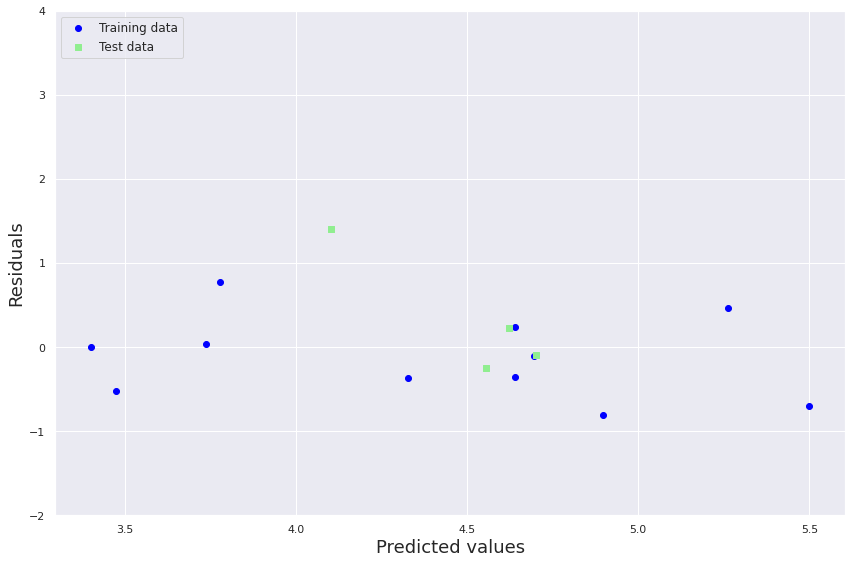

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(oof_pred.data[:, 0],  oof_pred.data[:, 0] - train_data['Porosity, %'].values,
            c='blue', marker='o', label='Training data')
plt.scatter(test_pred.data[:, 0],  test_pred.data[:, 0] - test_data['Porosity, %'].values,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values', fontsize=18)
plt.ylabel('Residuals', fontsize=18)
plt.legend(loc='upper left', prop={'size':12})
plt.ylim([-2, 4])
plt.tight_layout()

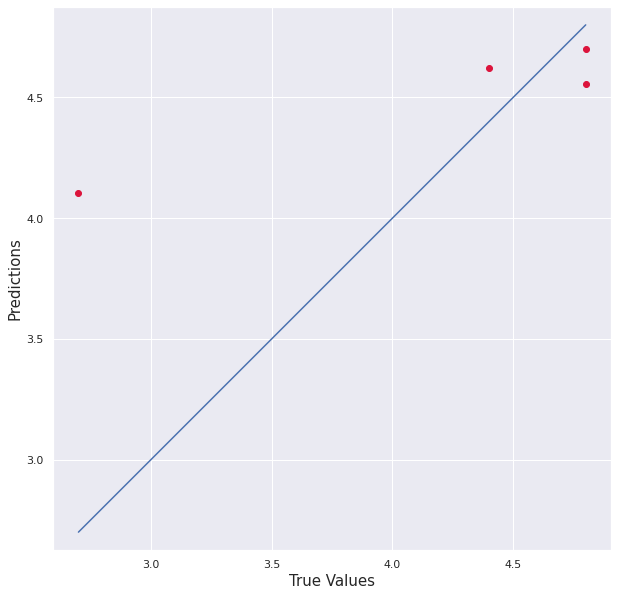

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(test_data['Porosity, %'].values, test_pred.data[:, 0], c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(test_pred.data[:, 0]), max(test_data['Porosity, %'].values))
p2 = min(min(test_pred.data[:, 0]), min(test_data['Porosity, %'].values))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

# Сохранение модели на диск

In [ ]:
# import pickle

# with open('AutoML_model_finalz5.pkl', 'wb') as f:
#     pickle.dump(automl, f)

In [ ]:
# import pickle

# filename = 'AutoML_model_finalz5.sav'
# pickle.dump(automl, open(filename, 'wb'))

In [ ]:
import joblib
joblib.dump(automl, 'trained_model.pkl')
automl = joblib.load('trained_model.pkl')

# Создание упрощенной модели

In [ ]:
!pip install catboost --no-cache-dir

     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [ ]:
from catboost import CatBoostRegressor

In [ ]:
train_data

,"I, A","P, Mpa","L, mm","V, mm/s","Porosity, %"
5,250,0.30,152,457.2,4.8
8,250,0.35,178,381.0,3.0
2,150,0.25,178,533.4,4.4
1,150,0.25,127,381.0,6.2
14,300,0.35,127,533.4,3.7
4,150,0.35,127,533.4,5.7
7,250,0.25,178,533.4,4.8
10,300,0.30,152,457.2,3.4
12,300,0.25,178,533.4,4.0
3,150,0.35,178,381.0,4.7


In [ ]:
test_data

,"I, A","P, Mpa","L, mm","V, mm/s","Porosity, %"
9,250,0.35,127,533.4,4.8
11,300,0.25,127,381.0,4.4
0,150,0.30,152,457.2,4.8
13,300,0.35,178,381.0,2.7


In [ ]:
y_train = train_data['Porosity, %'].values
X_train = train_data.drop(columns=['Porosity, %'])

In [ ]:
y_test = test_data['Porosity, %'].values
X_test = test_data.drop(columns=['Porosity, %'])

In [ ]:
model = CatBoostRegressor(iterations=3000, max_depth=2, l2_leaf_reg=1e-05, min_data_in_leaf=1,
                          random_seed=42,
                          eval_metric='R2',
                          custom_metric=['MAE', 'MAPE']
                          )
model.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose_eval=100,
          use_best_model=True,
          )

0:	learn: 0.0353203	test: -0.1291001	best: -0.1291001 (0)	total: 48.5ms	remaining: 2m 25s
100:	learn: 0.8662712	test: 0.7654807	best: 0.7654807 (100)	total: 73.7ms	remaining: 2.12s
200:	learn: 0.9574922	test: 0.8229268	best: 0.8240363 (178)	total: 104ms	remaining: 1.45s
300:	learn: 0.9784443	test: 0.8131903	best: 0.8240363 (178)	total: 125ms	remaining: 1.12s
400:	learn: 0.9848833	test: 0.8181314	best: 0.8240363 (178)	total: 169ms	remaining: 1.09s
500:	learn: 0.9900364	test: 0.8201187	best: 0.8240816 (418)	total: 215ms	remaining: 1.07s
600:	learn: 0.9901623	test: 0.8185711	best: 0.8240816 (418)	total: 254ms	remaining: 1.01s
700:	learn: 0.9915054	test: 0.8155350	best: 0.8240816 (418)	total: 300ms	remaining: 984ms
800:	learn: 0.9925231	test: 0.8187597	best: 0.8240816 (418)	total: 339ms	remaining: 930ms
900:	learn: 0.9967840	test: 0.8361832	best: 0.8367174 (884)	total: 367ms	remaining: 855ms
1000:	learn: 0.9986265	test: 0.8259859	best: 0.8367174 (884)	total: 410ms	remaining: 819ms
1100:	le

In [ ]:
model.save_model('CatBoost_model')

In [ ]:
CatBoost = CatBoostRegressor()

CatBoost.load_model('/content/CatBoost_model')

In [ ]:
test_pred = CatBoost.predict(test_data)

In [ ]:
train_pred = CatBoost.predict(train_data)

In [ ]:
test_pred

array([4.77128534, 3.78725249, 5.13878274, 2.70382755])

In [ ]:
test_data['Porosity, %'].values

array([4.8, 4.4, 4.8, 2.7])

In [ ]:
print('R^2 train: {:.3f}'.format(r2_score(train_data['Porosity, %'].values, train_pred)))

R^2 train: 0.996


In [ ]:
print('R^2 test: {:.3f}'.format(r2_score(test_data['Porosity, %'].values, test_pred)))

R^2 test: 0.837


In [ ]:
print('Median_Absolute_Error   train: {:.3f}, test: {:.3f}'.format(
        median_absolute_error(train_data['Porosity, %'].values, train_pred), 
        median_absolute_error(test_data['Porosity, %'].values, test_pred)))

Median_Absolute_Error   train: 0.043, test: 0.184


In [ ]:
from sklearn.metrics import max_error
print('Maximum residual error   train: {:.3f}, test: {:.3f}'.format(
        max_error(train_data['Porosity, %'].values, train_pred), 
        max_error(test_data['Porosity, %'].values, test_pred)))

Maximum residual error   train: 0.101, test: 0.613


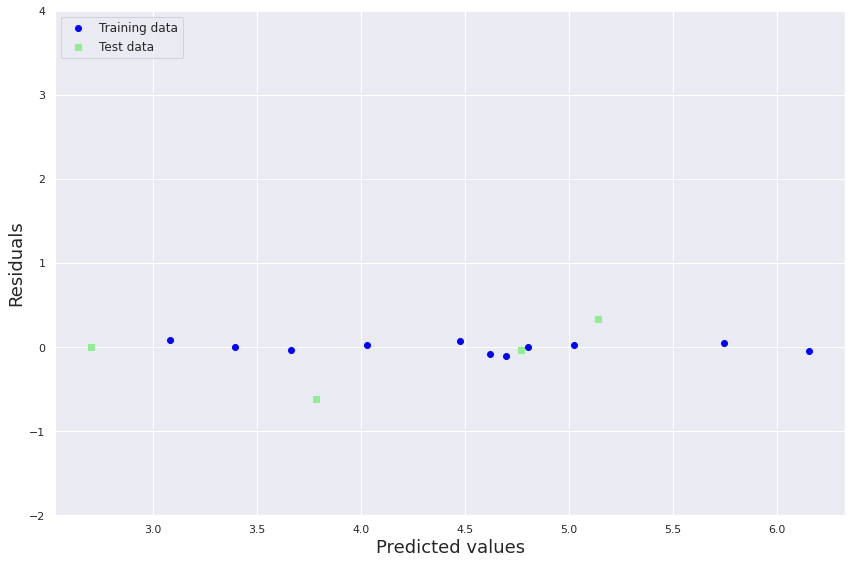

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(train_pred,  train_pred - train_data['Porosity, %'].values,
            c='blue', marker='o', label='Training data')
plt.scatter(test_pred,  test_pred - test_data['Porosity, %'].values,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values', fontsize=18)
plt.ylabel('Residuals', fontsize=18)
plt.legend(loc='upper left', prop={'size':12})
plt.ylim([-2, 4])
plt.tight_layout()

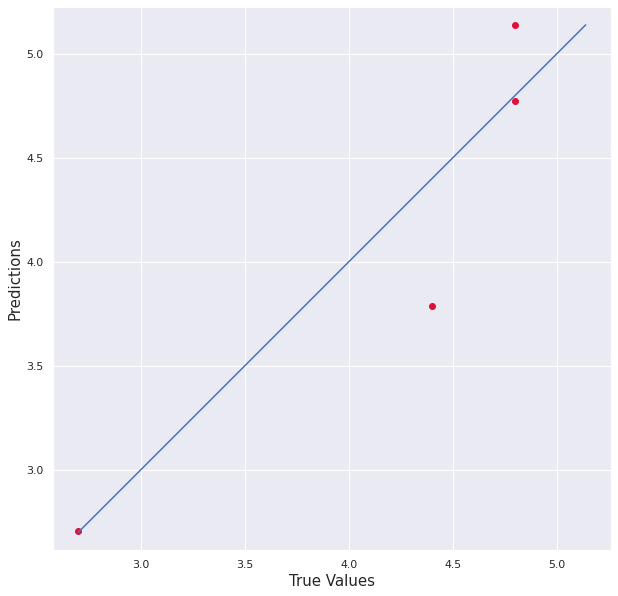

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(test_data['Porosity, %'].values, test_pred, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(test_pred), max(test_data['Porosity, %'].values))
p2 = min(min(test_pred), min(test_data['Porosity, %'].values))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

#Деплой модели

In [ ]:
!pip install flask gevent requests pillow

     |████████████████████████████████| 5.8 MB 13.4 MB/s 
     |████████████████████████████████| 251 kB 64.9 MB/s 


In [ ]:
procfile = 'web: gunicorn app:app'
procfiles= open("/content/Procfile","w")
procfiles.write(procfile)
procfiles.close()

In [ ]:
!pip install flask-ngrok
from flask_ngrok import run_with_ngrok
from flask import Flask

In [ ]:
!mkdir -p /drive/ngrok-ssh
%cd /drive/ngrok-ssh
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip -O ngrok-stable-linux-amd64.zip
!unzip -u ngrok-stable-linux-amd64.zip
!cp /drive/ngrok-ssh/ngrok /ngrok
!chmod +x /ngrok

/drive/ngrok-ssh
--2022-05-06 02:22:41--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 54.161.241.46, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  14.1MB/s    in 0.9s    

2022-05-06 02:22:42 (14.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
!/ngrok authtoken 1onGkGrYEfD1lfjfK3Q8hGy6THG_2WoecEp5KJbYNfyzen9Ev

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
!pip install xlsxwriter

     |████████████████████████████████| 149 kB 8.8 MB/s 


In [ ]:
!mkdir '/content/templates'
!mkdir '/content/uploads'

In [ ]:
from io import BytesIO
import os
import pandas as pd
import numpy as np
import joblib
import pickle
from flask import Flask, jsonify, request, redirect, url_for, send_from_directory, render_template, render_template_string, send_file

from flask import send_file
from werkzeug.utils import secure_filename

from catboost import CatBoostRegressor

import torch

ALLOWED_EXTENSIONS = set(['csv', 'xlsx'])
UPLOAD_FOLDER = '/content/uploads'
model = None
app = Flask(__name__)
run_with_ngrok(app)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

global title
global source

title = "Главная страница"
source = """<!doctype html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap.min.css">
<script src="https://ajax.googleapis.com/ajax/libs/jquery/3.1.1/jquery.min.js" type="text/javascript"></script>
<script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/js/bootstrap.min.js" type="text/javascript"></script>
  <title>Prediction Server</title>
  <body class style="margin:10px;padding:10px">
    <div class="page-header" id="banner">
      <div class="row">
        <div class="col-lg-8 col-md-7 col-sm-6">
          <h3>Prediction Server</h3>
          <p class="lead">Upload the arc spraying parameters</p>
        </div>
      </div>
      <form action="" method=post enctype=multipart/form-data>
        <input type=file name=file>
        <input type=submit value=Upload>
    </form>
    </div>
    <p style="margin-bottom:2cm;"></p>
    <div class="row">
        <div class="col-lg-4">
          <div class="page-header">
            <h3 id="tables">Result</h3>
          </div>
          <div class="bs-component">
            <table class="table table-hover">
                <tr class="table-active">
                 
                  <th scope="col">Predict</th>
                </tr>
                <tr>
                         <td> {{label}} </td>
                  </tr>
            </table> 
        </div>
      </div>
  </body>"""

def load_model():
    global model
    model = CatBoost.load_model('/content/CatBoost_model')

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1] in ALLOWED_EXTENSIONS

def predict(file):
    usecols = ['I, A', 'P, Mpa', 'L, mm', 'V, mm/s', 'Porosity, %']
    data = pd.read_excel(file, usecols = usecols)
    y = data['Porosity, %'].astype(float)
    data = data.drop(columns=['Porosity, %'])
    X = data
    result = CatBoost.predict(X)
    predPorosity = result
    pred = predPorosity[:, np.newaxis]
    pred = pd.DataFrame(data=pred, columns=["Porosity, %_predicted"])
    real = pd.DataFrame(data=y, columns=["Porosity, %"])
    res = pd.concat([data, real, pred], axis=1)
    return res
    
@app.route("/")
def template_test():
    return render_template_string(source, h1=title)

@app.route('/', methods=['POST', 'GET'])
def upload_file():
    
        file = request.files['file']
        
        if file and allowed_file(file.filename):
            global filename
            global output
            filename = secure_filename(file.filename)
            file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(file_path)
            result = predict(file_path)
            #create an output stream
            output = BytesIO()
            writer = pd.ExcelWriter(output, engine='xlsxwriter')

            #taken from the original question
            result.to_excel(writer, startrow = 0, merge_cells = False, sheet_name = "Sheet_1")
            workbook = writer.book
            worksheet = writer.sheets["Sheet_1"]
            format = workbook.add_format()
            format.set_bg_color('#eeeeee')
            worksheet.set_column(0,9,18)

            #the writer has done its job
            writer.close()

            #go back to the beginning of the stream
            output.seek(0)

        #finally return the file
        return send_file(output, attachment_filename="testing.xlsx", as_attachment=True)

if __name__ == "__main__":
    load_model()
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


[2022-05-06 03:04:18,161] (INFO):  * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://51c4-34-141-209-15.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


[2022-05-06 03:04:22,526] (INFO): 127.0.0.1 - - [06/May/2022 03:04:22] "GET / HTTP/1.1" 200 -
[2022-05-06 03:04:24,847] (INFO): 127.0.0.1 - - [06/May/2022 03:04:24] "GET / HTTP/1.1" 200 -
[2022-05-06 03:04:29,521] (INFO): 127.0.0.1 - - [06/May/2022 03:04:29] "GET / HTTP/1.1" 200 -
[2022-05-06 03:04:31,729] (INFO): 127.0.0.1 - - [06/May/2022 03:04:31] "GET /favicon.ico HTTP/1.1" 404 -
[2022-05-06 03:04:46,725] (INFO): 127.0.0.1 - - [06/May/2022 03:04:46] "POST / HTTP/1.1" 200 -
